# Modeling randomness

Theoretical distributions like the normal, student's t, exponential and even uniform are used because they mimic patterns of randomness we observe in the real world. For many distributions, we can derive deep theoretical reasons for why they keep popping up in everyday experience. It is also the case that sometimes a particular distribution will be used in a particular case mostly because of its convenient analytical properties.

In this notebook, we'll learn in general how to work with 
 - probability density functions (PDFs)
 - cumulative distribution functions (CDFs)
 - percentile or percentile point functions (PPFs)

We'll also see how to generate random numbers drawn from any distribution we like.

Building on what we've already learned about the uniform distribution, we'll also cover specific examples for the exponential and the normal distributions. What we learn from those examples will generalize to any other distribution we might need to work with.

## The exponential distribution

Before we cover the technical details for the exponential distribution, let's review a small example of how we might encounter this distribution "in the wild."

### Call center timing

Suppose you are a call center worker, and you know from past experience/data that you receive 5 calls per hour on average. Each call is very brief, taking about 1 minute to resolve. You'd like to know frequently you'll randomly have a natural break of at least 30 minutes between calls.

Suppose you don't know stats, but you have access to a computer and know how to code. You decide to set up a numerical simulation of call arrivals. You assume that calls are equally likely to arrive at all times of the day--something which past experience has taught you is approximately true.

#### Simulation setup

You have an intuition that you can achieve a more accurate simulation by dividing time up into very small chunks, to minimize discretization error. You decide to model time by the millisecond, and run a simulation for an entire 40-hour work week.

The number of milliseconds in 40 hours is $1,000 \times 60 \times 60 \times 40 = 144,000,000$.

The arrival rate of calls per millisecond will be $\frac{5}{1,000 \times 60 \times 60} = \frac{1}{720,000}$

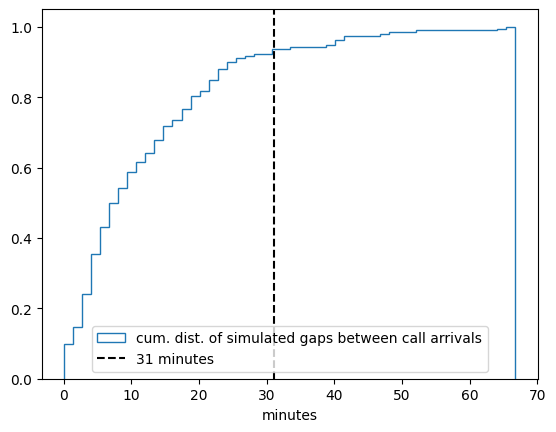

In [85]:
millisecond_random_draws = np.random.rand(144000000)

arrivals_per_hour = 5

arrivals_per_millisecond = arrivals_per_hour/3600000

simulated_arrivals = np.arange(144000000)[millisecond_random_draws < arrivals_per_millisecond]

minute_timegaps = (simulated_arrivals[1:] - simulated_arrivals[0:-1])/60000

plt.figure()
plt.hist(minute_timegaps,bins=50,density=True,cumulative=True,histtype='step',label='cum. dist. of simulated gaps between call arrivals')
plt.axvline(31,color='k',linestyle='--',label='31 minutes')
plt.legend()
plt.xlabel('minutes')
plt.show()


You can see as the result of your simulation that you can expect a natural gap of 30 minutes between the *end* of one call and the start of the next one (31 minutes between the *start* of one and the start of the next) about 10% of the time.

You also notice that you can expect to receive a new call in *less* than one minute, requiring the caller to wait or be re-routed to another worker, about 10% of the time. A detail which could be important for management!

#### A friend who knows statistics

After running this simulation and feeling pretty good about the results, you run into your friend who knows statistics. After describing the problem to her, she suggests that you could also answer your question--and with much lower computational cost--by just referencing the exponential distribution.

She tells you that the PDF of this distribution is $$f(x) = \lambda e^{-\lambda x}$$ for $x > 0$. And the CDF is $$F(x) = 1 - e^{-\lambda x}.$$

$\lambda$ in the above formulas is the arrival rate per unit of time. In terms of minutes, $\lambda = \frac{5}{60} = \frac{1}{12}$. To make her point, your friend draws the following graph for you, super-imposing the exponential CDF on your simulation:

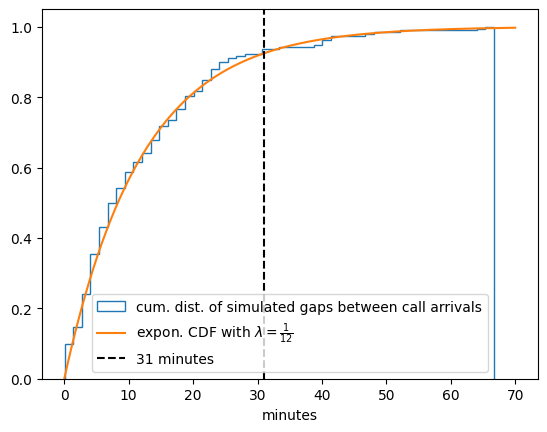

In [89]:
arrivals_per_minute = arrivals_per_hour/60

exponential_cdf = lambda x,lambd: 1-np.exp(-lambd*x)

x_grid = np.linspace(0,70,1000)

plt.figure()
plt.hist(minute_timegaps,bins=50,density=True,cumulative=True,histtype='step',label='cum. dist. of simulated gaps between call arrivals')
plt.plot(x_grid,exponential_cdf(x_grid,arrivals_per_minute),label='expon. CDF with $\\lambda = \\frac{1}{12}$')
plt.axvline(31,color='k',linestyle='--',label='31 minutes')
plt.legend()
plt.xlabel('minutes')
plt.show()

Finally, your friend tells you that you could just make one small calculation using the CDF. $F(31;\frac{1}{12}) = 1-e^{-\frac{31}{12}} \approx 0.924$, meaning that you would actually have larger than 30 minute gaps a bit less than 10% of the time.

As for the less than 1 minute gaps, $F(1;\frac{1}{12}) = 1-e^{-\frac{1}{12}} \approx 0.080$, meaning that there would be a conflict between two calls about 8% of the time.

### Generating exponentially-distributed random variables

Your friend further advises you that in case you want to run another simulation, you could get similar results by running it at the *minute* level of granularity and drawing from an appropriate exponential distribution.

*But how do I do that??* you ask her. *All I know how to generate is standard uniform random numbers!*

Your friend then informs you that if you feed a standard uniform draw into the percentile point function (PPF) of any other distribution, the result will be distributed same as the owner of the PPF.

The PPF is just the inverse of the CDF. For the exponential:

$$\begin{align}p &= 1 - e^{-\lambda x}\\
1-p&=  e^{-\lambda x}\\
\log [1-p]&=  -\lambda x\\
F^{-1}(p) &= -\frac{\log [1-p]}{\lambda}\end{align}$$

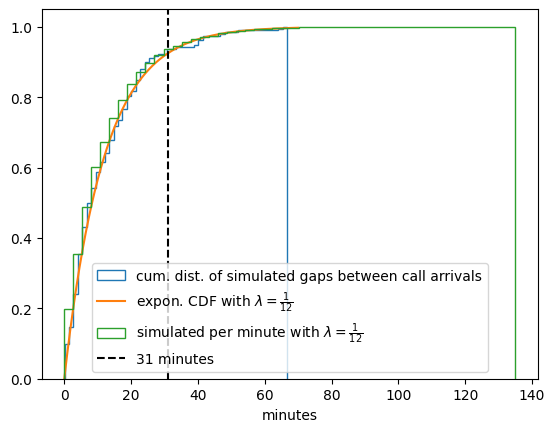

In [99]:
exponential_ppf = lambda p,lambd: -np.log(1-p)/lambd

minute_random_draws = np.random.rand(2400)

plt.figure()
plt.hist(minute_timegaps,bins=50,density=True,cumulative=True,histtype='step',label='cum. dist. of simulated gaps between call arrivals')
plt.plot(x_grid,exponential_cdf(x_grid,arrivals_per_minute),label='expon. CDF with $\\lambda = \\frac{1}{12}$')
plt.hist(exponential_ppf(minute_random_draws,1/12),bins=50,density=True,cumulative=True,histtype='step',label='simulated per minute with $\\lambda = \\frac{1}{12}$')
plt.axvline(31,color='k',linestyle='--',label='31 minutes')
plt.legend()
plt.xlabel('minutes')
plt.show()

### The exponential distribution in popular packages

In case you don't want to code your own PDF, CDF, and PPF for the exponential, you can use the `pdf()`, `cdf()` and `ppf()` functions from the `expon` module of the `scipy.stats` package.

You will need to pass the `scale` parameter. `scale` is $\frac{1}{\lambda}$. See below:

In [100]:
import scipy as sp

print(sp.stats.expon.cdf(31,scale=12),exponential_cdf(31,1/12))

0.9244781554912263 0.9244781554912263


You can also generate exponential random numbers direction using `numpy.random.exponential()`. You'll also need to pass a `scale` parameter, and scale is also the inverse of $\lambda$.

### Quick exercise

  - Verify that feeding standard uniform draws to `scipy.stats.expon.ppf()` is the same as using `numpy.random.exponential()` and both actually draw from an appropriate exponential distribution by plotting the empirical PDFs of the two random draws plus the theoretical PDF of the relevant exponential distribution all on the same graph.

## Normal distribution

The PDF of the normal distribution is given by $$f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}}$$

...and the CDF is not representable in terms of elementary functions.

### Normal CDF and PPF

You can use the `cdf()` and `ppf()` functions from the `scipy.stats.norm` module. If you want something other than the standard normal, you'll need to provide `loc` and `scale` parameters. `loc` is $\mu$, and `scale` is $\sigma$.

You can also use the `pdf()` function for the PDF.

### Normally-distributed random variables

In addition to the Box-Muller transform we mentioned last time, you can also obtain these by feeding standard uniform draws into the normal PPF or by using the `randn()` function from `numpy.random`. `randn()` does not take arguments for $\mu$ or $\sigma$--but due to the nature of the normal distribution, you can simply multiply your standard normal draw by $\sigma$ and add $\mu$ for the same effect.

### Quick exercise

  1. generate a large number of draws from a normal distribution with $\mu = 5$ and $\sigma = 3$ using `scipy.stats.norm.ppf()`
  2. generate a large number of draws from the same distribution using `numpy.rand.randn()`
  3. write a custom function to compute the normal PDF for a given $\mu$ and $\sigma$
  4. confirm that the results from (1) and (2) and equivalent and correct by plotting the two empirical PDFs and the corresponding theoretical PDF all on the same graph
  5. 